In [41]:
# imports
import os
import time

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import PIL.Image as Image
import trimesh
import torch
from torch import from_numpy, Tensor

from v_prism.utils.ui import abspath, mkdir_if_not_exists
from v_prism.utils.visualization import gen_image_of_trimesh_scene, gen_mesh_for_sdf_batch_3d
from v_prism.utils.subsample import grid_subsample, grid_subsample_different_res
from v_prism.mapping.v_prism import VPRISM
from v_prism.mapping.hinge_point_generation import generate_hingepoint_grid_for_multiple_objects
from v_prism.mapping.hinge_point_generation import generate_hingepoint_grid_multiple_objects_w_surface
from v_prism.utils.kernels import GaussianKernel
from v_prism.data_loading.negative_sampling import negative_sample_rays_in_sphere_uniform_each_step_multiclass
from v_prism.data_loading.negative_sampling import add_negative_points_below_plane
from v_prism.data_loading.negative_sampling import add_negative_points_below_plane_multiple_objects 
from v_prism.utils.ransac import robust_ransac, project_onto_plane, Plane
from v_prism.utils.pointsdf import PointSDF, scale_and_center_object_points
from v_prism.utils.pointsdf import scale_and_center_queries, index_points
from v_prism.utils.pointsdf import  farthest_point_sample


In [42]:
# helper stuff

scenes_dir = abspath("~/Documents/realsense_scenes_paper")


def create_cmap(ncolors: int):
    return {i: np.random.random(3) for i in range(1, ncolors+1)}

def create_seg_img(rgb: NDArray, seg_map: NDArray, cmap: dict | None = None) -> NDArray:
    """rgb is (H, W, 3), seg_map is (H, W). Returns (H, W, 3)"""
    r_img = np.copy(rgb)
    ids = np.unique(seg_map)
    for id in ids:
        if id == 0:
            continue
        rand_color = np.random.random(3) if cmap is None else cmap[int(id)]
        mask = seg_map == id
        r_img[mask] = 0.3 * r_img[mask] + 0.7 * rand_color
    return r_img



rgb: (360, 640, 3)
seg: (360, 640)
(360, 360, 3)


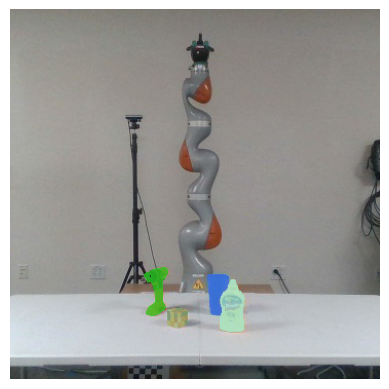

In [43]:
# seg image
scene_dir = os.path.join(scenes_dir, "00000001")

rgb_path = os.path.join(scene_dir, "rgb.jpg")
seg_path = os.path.join(scene_dir, "seg_mask.npy")

rgb = np.asarray(Image.open(rgb_path))
rgb = rgb / 255
print(f"rgb: {rgb.shape}")
seg_map = np.load(seg_path)[:, :, 0]
print(f"seg: {seg_map.shape}")

cmap = create_cmap(np.max(seg_map))

seg_img = create_seg_img(rgb, seg_map, cmap=cmap)

seg_img_square = seg_img[:, 140:500]
print(seg_img_square.shape)

plt.imshow(seg_img_square)
plt.axis("off")
plt.show()

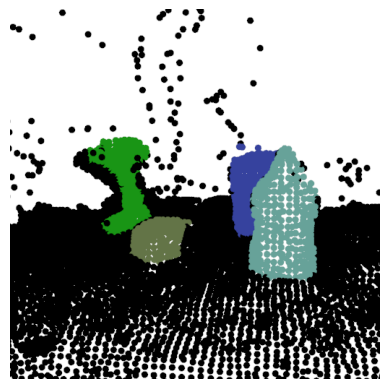

In [44]:
# pointcloud

resolution = 0.01
radius_for_obj = 0.3

# scene_dir = os.path.join(scenes_dir, "00000000")

rgb_path = os.path.join(scene_dir, "rgb.jpg")
xyz_path = os.path.join(scene_dir, "xyz.npy")
seg_path = os.path.join(scene_dir, "seg_mask.npy")

rgb = np.asarray(Image.open(rgb_path))
rgb = rgb / 255
xyz = np.load(xyz_path)
seg_map = np.load(seg_path)[:, :, 0]

points = np.reshape(xyz, (-1, 3))
seg_mask = np.reshape(seg_map, -1)

depth = np.linalg.norm(points, axis=1)

points_valid_mask = depth > 0.1

points = points[points_valid_mask]
seg_mask = seg_mask[points_valid_mask]


points_torch, seg_torch = grid_subsample(from_numpy(points), from_numpy(seg_mask), resolution)

points = points_torch.numpy()
seg_mask = seg_torch.numpy()



pointclouds = []


for id in np.unique(seg_mask[seg_mask > 0]):
    mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
    dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
    mask = np.logical_and(dist_to_mean_all_pts <= radius_for_obj, seg_mask == id)
    neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
    seg_mask[neg_mask] = 0
    
    pc = trimesh.PointCloud(points[mask])
    pc.visual.vertex_colors = cmap[int(id)]
    pointclouds.append(pc)
radius = 0.5
scene_center = 0.5 * (np.max(points[seg_mask > 0], axis=0) + np.min(points[seg_mask > 0], axis=0))
nearby_not_object_points = points[np.logical_and(seg_mask == 0, np.linalg.norm(points - scene_center, axis=1) <= radius)]

pointcloud_not_obj = trimesh.PointCloud(nearby_not_object_points)

view_params = {
    "theta": 0.5 * np.pi,
    "phi": 0.05 * np.pi,
    "pi": 0.95 * np.pi, 
    "rho": 0.8,
    "line_settings": {"point_size": 10}
}

mesh_img = gen_image_of_trimesh_scene(
    trimesh.Scene([pointcloud_not_obj, *pointclouds]),
    **view_params,
    lookat_position=scene_center
    # theta=0.5 * np.pi,
    # # phi = 0.2 * np.pi,
    # phi = 0.05 * np.pi,
    # pi = 0.95 * np.pi, 
    # # pi = 1.0 * np.pi, 
    # rho=0.8,
    # lookat_position=scene_center,
    # line_settings={'point_size': 10}
)


plt.imshow(mesh_img)
plt.axis("off")
plt.show()


points: torch.Size([215323, 3])
seg_mask: torch.Size([215323])
using device: cuda
hinge_points: torch.Size([464, 3])
X: torch.Size([973, 3])


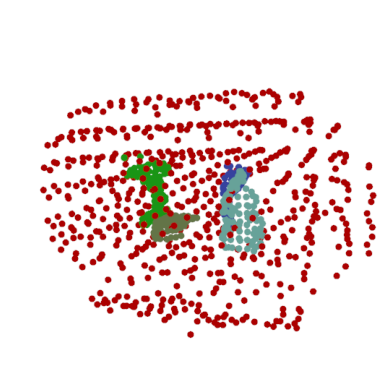

In [45]:
# negative samples
resolution = 0.01
subsample_grid_size_unocc = 0.015
subsample_grid_size_occ = 0.01
radius_for_obj = 0.3
object_sphere_radius = 0.3
scene_sphere_radius = 0.5
grid_len = 0.05
kernel_param = 750
ray_step_size = 0.1
grid_dist_from_obj = 0.15
num_surface_points = 32
# scene_dir = os.path.join(scenes_dir, "00000000")


rgb_path = os.path.join(scene_dir, "rgb.jpg")
xyz_path = os.path.join(scene_dir, "xyz.npy")
seg_path = os.path.join(scene_dir, "seg_mask.npy")
rgb = np.asarray(Image.open(rgb_path))
rgb = rgb / 255
xyz = np.load(xyz_path)
seg_map = np.load(seg_path)[:, :, 0]
points = np.reshape(xyz, (-1, 3))
seg_mask = np.reshape(seg_map, -1)
# pre process points
depth = np.linalg.norm(points, axis=1)
points_valid_mask = depth > 0.1
points = points[points_valid_mask]
seg_mask = seg_mask[points_valid_mask]
for id in np.unique(seg_mask[seg_mask > 0]):
    mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
    dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
    neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
    seg_mask[neg_mask] = 0

points = from_numpy(points)
seg_mask = from_numpy(seg_mask)
print(f"points: {points.shape}")
print(f"seg_mask: {seg_mask.shape}")

start = time.time()
device = torch.device("cuda")
print(f"using device: {device}")

hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
    points, seg_mask, grid_len, grid_dist_from_obj, num_surface_points
)
print(f"hinge_points: {hinge_points.shape}")
kernel = GaussianKernel(kernel_param)
# (3) neg sampling on data
scene_center = 0.5 * (
    torch.amax(points[seg_mask > 0], dim=0) 
    + torch.amin(points[seg_mask > 0], dim=0)
)
X, y = negative_sample_rays_in_sphere_uniform_each_step_multiclass(
    points=points, 
    mask=seg_mask, 
    step_size=ray_step_size, 
    radius=object_sphere_radius,
)
plane = robust_ransac(points, seg_mask, 400, dist_tol=0.01, radius=scene_sphere_radius)
X, y = add_negative_points_below_plane_multiple_objects(
    X, y, plane=[*list(plane.normal_vect), -plane.bias], center=scene_center, radius=object_sphere_radius, k=1000
)

X, y = grid_subsample_different_res(
    X, 
    y, 
    subsample_grid_size_unocc=0.08, 
    subsample_grid_size_occ=0.02
)
print(f"X: {X.shape}")

num_classes = len(seg_mask.unique())

pcs = []
for i in range(0, num_classes):
    pc_i = trimesh.PointCloud(X[y == i])
    if i == 0:
        color = np.array([1.0, 0, 0])
    else:
        color = cmap[i]
    pc_i.visual.vertex_colors = color
    pcs.append(pc_i)

_view_params = {
    "theta": 0.5 * np.pi,
    "phi": 0.05 * np.pi,
    "pi": 0.9 * np.pi, 
    "rho": 1.2,
    "line_settings": {"point_size": 10}
}

img = recon_mesh_img = gen_image_of_trimesh_scene(
    trimesh.Scene([pcs]),
    **_view_params,
    lookat_position=scene_center
)

plt.imshow(img)
plt.axis("off")
plt.show()


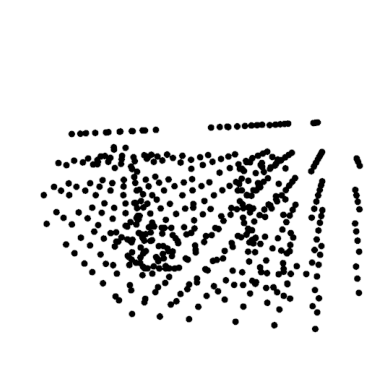

In [46]:
# hingepoints

hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
    points, seg_mask, grid_len, grid_dist_from_obj, num_surface_points
)

pc = trimesh.PointCloud(hinge_points)

_view_params = {
    "theta": 0.5 * np.pi,
    "phi": 0.05 * np.pi,
    "pi": 0.9 * np.pi, 
    "rho": 0.75,
    "line_settings": {"point_size": 10}
}

img = recon_mesh_img = gen_image_of_trimesh_scene(
    trimesh.Scene(pc),
    **_view_params,
    lookat_position=scene_center
)
plt.imshow(img)
plt.axis("off")
plt.show()

points: torch.Size([215323, 3])
seg_mask: torch.Size([215323])
using device: cuda
hinge_points: torch.Size([464, 3])
X: torch.Size([47700, 3])
fit in 3.6879327297210693 seconds


100%|██████████| 134/134 [00:00<00:00, 4112.33it/s]


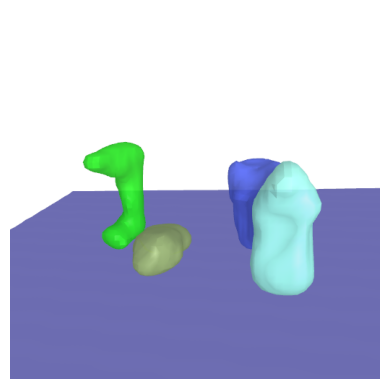

In [47]:
# reconstruction

resolution = 0.01
subsample_grid_size_unocc = 0.015
subsample_grid_size_occ = 0.01
radius_for_obj = 0.3
object_sphere_radius = 0.3
scene_sphere_radius = 0.5
grid_len = 0.05
kernel_param = 750
ray_step_size = 0.1
grid_dist_from_obj = 0.15
num_surface_points = 32
# scene_dir = os.path.join(scenes_dir, "00000000")


rgb_path = os.path.join(scene_dir, "rgb.jpg")
xyz_path = os.path.join(scene_dir, "xyz.npy")
seg_path = os.path.join(scene_dir, "seg_mask.npy")
rgb = np.asarray(Image.open(rgb_path))
rgb = rgb / 255
xyz = np.load(xyz_path)
seg_map = np.load(seg_path)[:, :, 0]
points = np.reshape(xyz, (-1, 3))
seg_mask = np.reshape(seg_map, -1)
# pre process points
depth = np.linalg.norm(points, axis=1)
points_valid_mask = depth > 0.1
points = points[points_valid_mask]
seg_mask = seg_mask[points_valid_mask]
for id in np.unique(seg_mask[seg_mask > 0]):
    mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
    dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
    neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
    seg_mask[neg_mask] = 0

points = from_numpy(points)
seg_mask = from_numpy(seg_mask)
print(f"points: {points.shape}")
print(f"seg_mask: {seg_mask.shape}")

start = time.time()
hinge_points = generate_hingepoint_grid_for_multiple_objects(points, seg_mask, resolution=0.04, dist_from_obj=0.2)

device = torch.device("cuda")
print(f"using device: {device}")

hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
    points, seg_mask, grid_len, grid_dist_from_obj, num_surface_points
)
print(f"hinge_points: {hinge_points.shape}")
kernel = GaussianKernel(kernel_param)
# (2) create map
vprism_map = VPRISM(
    num_classes=int(torch.amax(seg_mask).item()) + 1,
    hinge_points=hinge_points,
    kernel=kernel,
    num_iterations=3,
).to(device)
# (3) neg sampling on data
scene_center = 0.5 * (
    torch.amax(points[seg_mask > 0], dim=0) 
    + torch.amin(points[seg_mask > 0], dim=0)
)
X, y = negative_sample_rays_in_sphere_uniform_each_step_multiclass(
    points=points, 
    mask=seg_mask, 
    step_size=ray_step_size, 
    radius=object_sphere_radius,
)
plane = robust_ransac(points, seg_mask, 400, dist_tol=0.01, radius=scene_sphere_radius)
X, y = add_negative_points_below_plane_multiple_objects(
    X, y, plane=[*list(plane.normal_vect), -plane.bias], center=scene_center, radius=scene_sphere_radius, k=10000
)

X, y = grid_subsample_different_res(
    X, 
    y, 
    subsample_grid_size_unocc=subsample_grid_size_unocc, 
    subsample_grid_size_occ=subsample_grid_size_occ
)
print(f"X: {X.shape}")
# (4) fit map
vprism_map.sequential_update(X.to(device), y.to(device), 20000)
end = time.time()
print(f"fit in {end - start} seconds")

num_classes = len(seg_mask.unique())

meshes = []
for i in range(1, num_classes):
    pred_func = lambda x: vprism_map.predict(x.to(device))[:, i].to(torch.device("cpu"))
    recon_mesh_i = gen_mesh_for_sdf_batch_3d(
        pred_func, 
        xlim=[scene_center[0] - 0.4, scene_center[0] + 0.4], 
        ylim=[scene_center[1] - 0.4, scene_center[1] + 0.4], 
        zlim=[scene_center[2] - 0.4, scene_center[2] + 0.4], 
        resolution=0.01,
    )
    color = np.array([0, 0, 0, 0.9])
    color[:3] = cmap[i]
    recon_mesh_i.visual.vertex_colors = color
    meshes.append(recon_mesh_i)

plane.normal_vect = plane.normal_vect.to(points.dtype)

plane_mesh = gen_mesh_for_sdf_batch_3d(
    lambda x: (x @ plane.normal_vect.to(x.dtype) + plane.bias < 0).to(x.dtype), 
    xlim=[scene_center[0] - 0.5, scene_center[0] + 0.5], 
    ylim=[scene_center[1] - 0.5, scene_center[1] + 0.5], 
    zlim=[scene_center[2] - 0.5, scene_center[2] + 0.5], 
    resolution=0.0075,
)

trimesh.smoothing.filter_laplacian(plane_mesh, iterations=50)

recon_mesh_img = gen_image_of_trimesh_scene(
    trimesh.Scene([plane_mesh, *meshes,]),
    **view_params,
    lookat_position=scene_center
)

plt.imshow(recon_mesh_img)
plt.axis("off")
plt.show()



tensor(1.5666, dtype=torch.float64) tensor(0.0018, dtype=torch.float64)


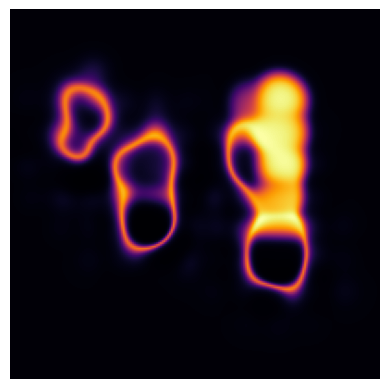

In [48]:
# heatmap

def entropy(x):
    out = vprism_map.predict(x.to(device)).cpu()  # (P, C)
    out = out * torch.log(out)
    out = - torch.sum(out, dim=1)
    return out

def gen_heatmap_xyz_grid(
    plane: Plane, 
    scene_center: Tensor, 
    height: float, 
    extent: float,  
    resolution: float, 
    *, 
    forward: Tensor = torch.tensor([0, 0, 1])
) -> Tensor:
    plane_no_bias = Plane(plane.normal_vect, 0.0)
    p = project_onto_plane(plane_no_bias, forward.reshape((1, 3)).to(plane_no_bias.normal_vect.dtype)).reshape(3)
    q = torch.cross(p, plane.normal_vect)
    center_proj = project_onto_plane(plane_no_bias, scene_center.reshape((1, 3))).reshape(3)
    p = p / (torch.norm(p) + 1e-9)
    q = q / (torch.norm(q) + 1e-9)
    range1 = np.arange(-extent, extent, resolution)
    L = range1.shape[0]
    ranges = [range1, -range1]
    pre_grid = torch.tensor(np.stack(np.meshgrid(*ranges), axis=-1))  # (L, L, 2)
    parallel_grid = pre_grid[:, :, 0].reshape(L, L, 1) * q + pre_grid[:, :, 1].reshape(L, L, 1) * p  # (L, L, 3)
    parallel_grid = parallel_grid + center_proj
    unit_normal_vect = plane.normal_vect / (torch.norm(plane.normal_vect) + 1e-9)
    unit_bias = plane.bias / (torch.norm(plane.normal_vect) + 1e-9)
    grid = parallel_grid + (height - unit_bias) * unit_normal_vect
    return grid  # (L, L, 3)

scene_center = 0.5 * (torch.amax(points[seg_mask > 0], dim=0) + torch.amin(points[seg_mask > 0], dim=0))
scene_center = 0.5 * (torch.mean(points[seg_mask > 0], dim=0)) + 0.5 * scene_center
heatmap_grid_xyz = gen_heatmap_xyz_grid(plane, scene_center, height=0.02, extent=0.3, resolution=0.003)

L1, L2, _ = heatmap_grid_xyz.shape

vals_entropy = entropy(heatmap_grid_xyz.reshape(L1 * L2, 3)).reshape(L1, L2)
# vals_entropy = torch.sqrt(vals_entropy)

print(torch.amax(vals_entropy), torch.amin(vals_entropy))

plt.imshow(vals_entropy, cmap="inferno")
plt.axis("off")
plt.show()




# pc = trimesh.PointCloud(heatmap_grid_xyz.reshape(-1, 3))
# pc.visual.vertex_colors = np.array([255, 0, 0])
# recon_mesh_img = gen_image_of_trimesh_scene(trimesh.Scene([pc, pointcloud_not_obj, *meshes]), **view_params)
# plt.imshow(recon_mesh_img)
# plt.axis("off")
# plt.show()

tensor(0.3341, dtype=torch.float64) tensor(3.6032e-06, dtype=torch.float64)


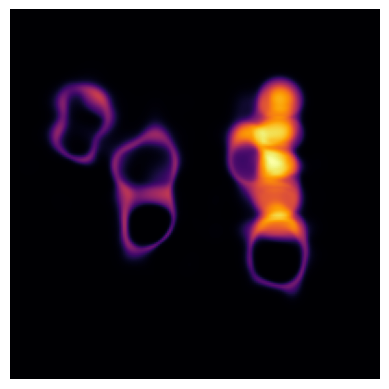

In [49]:
# variance

def entropy2(x):
    out = vprism_map.predict_sample(x.to(device), 30).cpu()   # (S, P, C)
    out = torch.mean(out, dim=0)
    out = out * torch.log(out)
    out = - torch.sum(out, dim=1)
    return out

def var(x):
    out = vprism_map.predict_sample(x.to(device), 30).cpu()   # (S, P, C)
    out = torch.std(out, dim=0)
    out = torch.mean(out, dim=1)
    return out

scene_center = 0.5 * (torch.amax(points[seg_mask > 0], dim=0) + torch.amin(points[seg_mask > 0], dim=0))
scene_center = 0.5 * (torch.mean(points[seg_mask > 0], dim=0)) + 0.5 * scene_center
heatmap_grid_xyz = gen_heatmap_xyz_grid(plane, scene_center, height=0.01, extent=0.3, resolution=0.003)

L1, L2, _ = heatmap_grid_xyz.shape

# vals = entropy2(heatmap_grid_xyz.reshape(L1 * L2, 3)).reshape(L1, L2)
vals = var(heatmap_grid_xyz.reshape(L1 * L2, 3)).reshape(L1, L2)
# vals = vals

print(torch.amax(vals), torch.amin(vals))

plt.imshow(vals, cmap="inferno")
plt.axis("off")
plt.show()


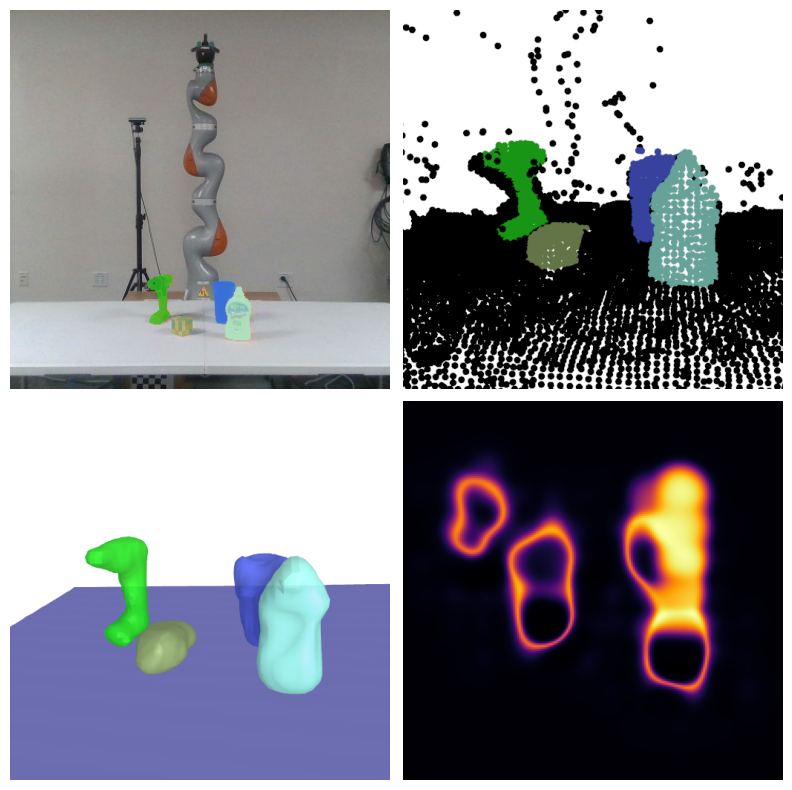

In [50]:
# fig 1 draft 1

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plt.axis("off")
plt.subplots_adjust(wspace=0.03, hspace=0.03)
axs[0, 0].set_axis_off()
axs[0, 1].set_axis_off()
axs[1, 0].set_axis_off()
axs[1, 1].set_axis_off()
axs[0, 0].imshow(seg_img_square)
axs[0, 1].imshow(mesh_img)
axs[1, 0].imshow(recon_mesh_img)
axs[1, 1].imshow(vals_entropy, cmap="inferno")
plt.show()


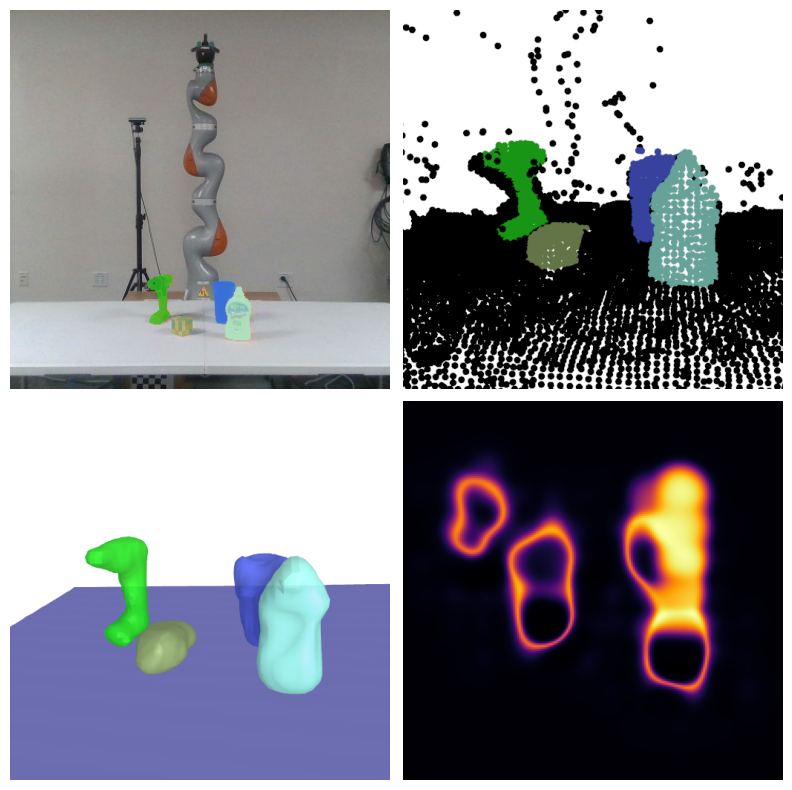

In [51]:
# fig 1 draft 1

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plt.axis("off")
plt.subplots_adjust(wspace=0.03, hspace=0.03)
axs[0, 0].set_axis_off()
axs[0, 1].set_axis_off()
axs[1, 0].set_axis_off()
axs[1, 1].set_axis_off()
axs[0, 0].imshow(seg_img_square)
axs[0, 1].imshow(mesh_img)
axs[1, 0].imshow(recon_mesh_img)
axs[1, 1].imshow(vals_entropy, cmap="inferno")
plt.show()


In [52]:
def gen_reconstruction_img_for_scene(
    scene_dir, cmap
):
    rgb_path = os.path.join(scene_dir, "rgb.jpg")
    xyz_path = os.path.join(scene_dir, "xyz.npy")
    seg_path = os.path.join(scene_dir, "seg_mask.npy")
    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    xyz = np.load(xyz_path)
    seg_map = np.load(seg_path)[:, :, 0]
    points = np.reshape(xyz, (-1, 3))
    seg_mask = np.reshape(seg_map, -1)
    # pre process points
    depth = np.linalg.norm(points, axis=1)
    points_valid_mask = depth > 0.1
    points = points[points_valid_mask]
    seg_mask = seg_mask[points_valid_mask]
    for id in np.unique(seg_mask[seg_mask > 0]):
        mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
        dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
        neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
        seg_mask[neg_mask] = 0

    points = from_numpy(points)
    seg_mask = from_numpy(seg_mask)
    print(f"points: {points.shape}")
    print(f"seg_mask: {seg_mask.shape}")

    start = time.time()
    hinge_points = generate_hingepoint_grid_for_multiple_objects(points, seg_mask, resolution=0.04, dist_from_obj=0.2)

    device = torch.device("cuda")

    hinge_points = generate_hingepoint_grid_multiple_objects_w_surface(
        points, seg_mask, grid_len, grid_dist_from_obj, num_surface_points
    )
    print(f"hinge_points: {hinge_points.shape}")
    kernel = GaussianKernel(kernel_param)
    # (2) create map
    vprism_map = VPRISM(
        num_classes=int(torch.amax(seg_mask).item()) + 1,
        hinge_points=hinge_points,
        kernel=kernel,
        num_iterations=3,
    ).to(device)
    # (3) neg sampling on data
    scene_center = 0.5 * (
        torch.amax(points[seg_mask > 0], dim=0) 
        + torch.amin(points[seg_mask > 0], dim=0)
    )
    X, y = negative_sample_rays_in_sphere_uniform_each_step_multiclass(
        points=points, 
        mask=seg_mask, 
        step_size=ray_step_size, 
        radius=object_sphere_radius,
    )
    plane = robust_ransac(points, seg_mask, 400, dist_tol=0.01, radius=scene_sphere_radius)
    X, y = add_negative_points_below_plane_multiple_objects(
        X, y, plane=[*list(plane.normal_vect), -plane.bias], center=scene_center, radius=scene_sphere_radius, k=10000
    )

    X, y = grid_subsample_different_res(
        X, 
        y, 
        subsample_grid_size_unocc=subsample_grid_size_unocc, 
        subsample_grid_size_occ=subsample_grid_size_occ
    )
    print(f"X: {X.shape}")
    # (4) fit map
    vprism_map.sequential_update(X.to(device), y.to(device), 20000)
    end = time.time()
    print(f"fit in {end - start} seconds")

    num_classes = len(seg_mask.unique())

    meshes = []
    for i in range(1, num_classes):
        pred_func = lambda x: vprism_map.predict(x.to(device))[:, i].to(torch.device("cpu"))
        recon_mesh_i = gen_mesh_for_sdf_batch_3d(
            pred_func, 
            xlim=[scene_center[0] - 0.4, scene_center[0] + 0.4], 
            ylim=[scene_center[1] - 0.4, scene_center[1] + 0.4], 
            zlim=[scene_center[2] - 0.4, scene_center[2] + 0.4], 
            resolution=0.01,
        )
        color = np.array([0, 0, 0, 0.9])
        color[:3] = cmap[i]
        recon_mesh_i.visual.vertex_colors = color
        meshes.append(recon_mesh_i)

    # plane.normal_vect = plane.normal_vect.to(points.dtype)

    plane_mesh = gen_mesh_for_sdf_batch_3d(
        lambda x: (x @ plane.normal_vect.to(x.dtype) + plane.bias < 0).to(x.dtype), 
        xlim=[scene_center[0] - 0.5, scene_center[0] + 0.5], 
        ylim=[scene_center[1] - 0.5, scene_center[1] + 0.5], 
        zlim=[scene_center[2] - 0.5, scene_center[2] + 0.5], 
        resolution=0.0075,
    )

    trimesh.smoothing.filter_laplacian(plane_mesh, iterations=40)

    recon_mesh_img = gen_image_of_trimesh_scene(
        trimesh.Scene([plane_mesh, *meshes,]),
        **view_params,
        lookat_position=scene_center
    )

    return recon_mesh_img

In [53]:
npoint = 256
model = torch.load(abspath("~/projects/v_prism/logs/models/pointsdf.pt"))  # <-- model path here
tau = 0.3

def reconstruct_scene_pointsdf(scene_dir: str, cmap) -> Image:
    rgb_path = os.path.join(scene_dir, "rgb.jpg")
    xyz_path = os.path.join(scene_dir, "xyz.npy")
    seg_path = os.path.join(scene_dir, "seg_mask.npy")
    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    xyz = np.load(xyz_path)
    # xyz[:, :, 1] = -xyz[:, :, 1]
    # xyz[:, :, 2] = -xyz[:, :, 2]
    seg_map = np.load(seg_path)[:, :, 0]
    points = np.reshape(xyz, (-1, 3))
    seg_mask = np.reshape(seg_map, -1)
    # pre process points
    depth = np.linalg.norm(points, axis=1)
    points_valid_mask = depth > 0.1
    points = points[points_valid_mask]
    seg_mask = seg_mask[points_valid_mask]
    for id in np.unique(seg_mask[seg_mask > 0]):
        mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
        dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
        neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
        seg_mask[neg_mask] = 0

    points = from_numpy(points).to(torch.float32)
    seg_mask = from_numpy(seg_mask)
    print(f"points: {points.shape}")
    print(f"seg_mask: {seg_mask.shape}")
    num_classes = int(torch.amax(seg_mask).item()) + 1
    obj_points_list = []
    for i in range(1, num_classes):
        point_cloud = points[seg_mask == i]
        sampled_points_idx = farthest_point_sample(point_cloud.unsqueeze(0), npoint=npoint)
        sampled_points = index_points(point_cloud.unsqueeze(0), sampled_points_idx)
        obj_points_list.append(sampled_points.reshape(npoint, 3))
    batched_points_uncentered = torch.stack(obj_points_list)  # (N, p, 3)
    obj_points, centers = scale_and_center_object_points(batched_points_uncentered)
    N = centers.shape[0]
    model.to(device)
    model.eval()
    with torch.no_grad():
        obj_feats = model.get_latent_features(obj_points.to(device))
    def occ_func(x: Tensor) -> Tensor:
        with torch.no_grad():
            query_pts = scale_and_center_queries(centers.to(device), x.to(torch.float).to(device).unsqueeze(0).repeat((N, 1, 1)))
            preds = model.get_preds(obj_feats, query_pts)  # (N, P)
        return preds.cpu()
    meshes = []    
    for i in range(N):
        occ_func_i = lambda x: occ_func(x)[i]
        mins = torch.amin(batched_points_uncentered[i], dim=0)
        maxs = torch.amax(batched_points_uncentered[i], dim=0)
        cntr = 0.5 * (mins + maxs)
        bound = 0.1
        mesh = gen_mesh_for_sdf_batch_3d(
            occ_func_i,
            xlim=[cntr[0] - 0.4, cntr[0] + 0.4], 
            ylim=[cntr[1] - 0.4, cntr[1] + 0.4], 
            zlim=[cntr[2] - 0.4, cntr[2] + 0.4], 
            resolution=0.01,
            confidence=tau
        )
        if mesh is None:
            print("empty mesh :-(")
            continue
        color = np.array([0, 0, 0, 0.9])
        color[:3] = cmap[i+1]
        mesh.visual.vertex_colors = color
        meshes.append(mesh)
        
    plane = robust_ransac(points, seg_mask, 500, dist_tol=0.01, radius=scene_sphere_radius)
    # plane.normal_vect = plane.normal_vect.to(points.dtype)
    scene_center = 0.5 * (
        torch.amax(points[seg_mask > 0], dim=0) 
        + torch.amin(points[seg_mask > 0], dim=0)
    )
    plane_mesh = gen_mesh_for_sdf_batch_3d(
        lambda x: (x @ plane.normal_vect.to(x.dtype) + plane.bias < 0).to(x.dtype), 
        xlim=[scene_center[0] - 0.5, scene_center[0] + 0.5], 
        ylim=[scene_center[1] - 0.5, scene_center[1] + 0.5], 
        zlim=[scene_center[2] - 0.5, scene_center[2] + 0.5], 
        resolution=0.0075,
    )

    trimesh.smoothing.filter_laplacian(plane_mesh, iterations=40)

    recon_mesh_img = gen_image_of_trimesh_scene(
        trimesh.Scene([plane_mesh, *meshes,]),
        **view_params,
        lookat_position=scene_center
    )

    return recon_mesh_img

    

points: torch.Size([215532, 3])
seg_mask: torch.Size([215532])


100%|██████████| 134/134 [00:00<00:00, 9833.90it/s]


points: torch.Size([215323, 3])
seg_mask: torch.Size([215323])


100%|██████████| 134/134 [00:00<00:00, 8527.98it/s]


points: torch.Size([215420, 3])
seg_mask: torch.Size([215420])


100%|██████████| 81/81 [00:02<00:00, 36.46it/s]


empty mesh :-(


100%|██████████| 134/134 [00:00<00:00, 9552.11it/s]


points: torch.Size([215515, 3])
seg_mask: torch.Size([215515])


100%|██████████| 134/134 [00:00<00:00, 8733.92it/s]


points: torch.Size([215256, 3])
seg_mask: torch.Size([215256])


100%|██████████| 134/134 [00:00<00:00, 8423.18it/s]


points: torch.Size([215532, 3])
seg_mask: torch.Size([215532])
hinge_points: torch.Size([497, 3])
X: torch.Size([46967, 3])
fit in 3.68215012550354 seconds


100%|██████████| 134/134 [00:00<00:00, 10626.92it/s]


points: torch.Size([215323, 3])
seg_mask: torch.Size([215323])
hinge_points: torch.Size([464, 3])
X: torch.Size([47550, 3])
fit in 3.5550520420074463 seconds


100%|██████████| 134/134 [00:00<00:00, 9463.81it/s]


points: torch.Size([215420, 3])
seg_mask: torch.Size([215420])
hinge_points: torch.Size([609, 3])
X: torch.Size([53081, 3])
fit in 6.983168363571167 seconds


100%|██████████| 134/134 [00:00<00:00, 10234.29it/s]


points: torch.Size([215515, 3])
seg_mask: torch.Size([215515])
hinge_points: torch.Size([426, 3])
X: torch.Size([41583, 3])
fit in 2.8058974742889404 seconds


100%|██████████| 134/134 [00:00<00:00, 8620.99it/s]


points: torch.Size([215256, 3])
seg_mask: torch.Size([215256])
hinge_points: torch.Size([357, 3])
X: torch.Size([39070, 3])
fit in 1.4192798137664795 seconds


100%|██████████| 134/134 [00:00<00:00, 10750.72it/s]


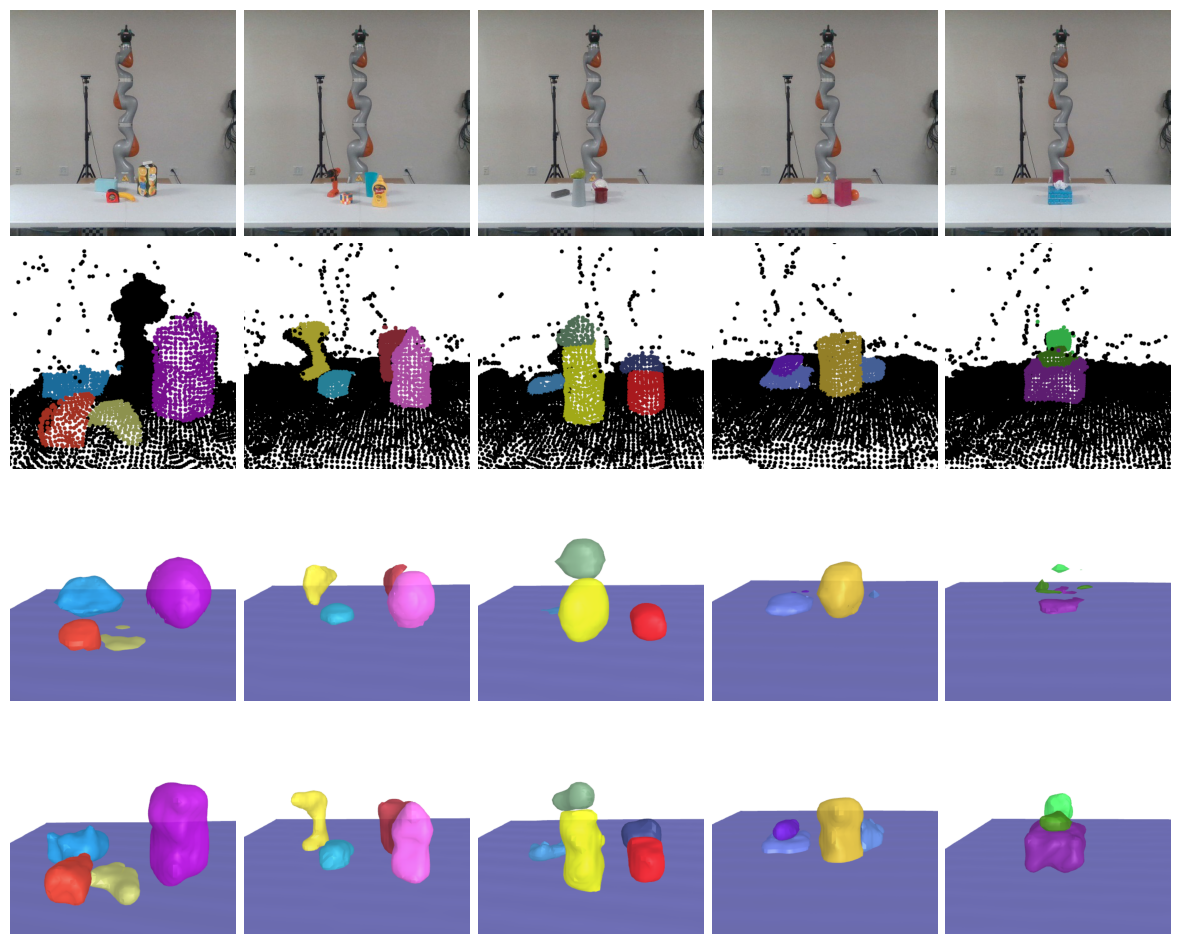

In [54]:
scene_dirs = [
    os.path.join(scenes_dir, "00000000"),
    os.path.join(scenes_dir, "00000001"),
    os.path.join(scenes_dir, "00000002"),
    os.path.join(scenes_dir, "00000004"),
    os.path.join(scenes_dir, "00000005")
]

# save_imgs_dir = abspath("~/Documents/tmp_imgs")
# mkdir_if_not_exists(save_imgs_dir)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))

plt.axis("off")
plt.subplots_adjust(wspace=0.03, hspace=0.03)

cmaps = [create_cmap(10) for i in range(5)]

# rgb + segmentation
for i, scene_dir in enumerate(scene_dirs):
    cmap = cmaps[i]
    rgb_path = os.path.join(scene_dir, "rgb.jpg")
    # seg_path = os.path.join(scene_dir, "seg_mask.npy")
    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    # seg_map = np.load(seg_path)[:, :, 0]
    # cmap = create_cmap(np.max(seg_map))
    # seg_img = create_seg_img(rgb, seg_map, cmap=cmap)
    # seg_img_square = seg_img[:, 140:500]
    rgb = rgb[:, 140:500]
    axs[0, i].set_axis_off()
    axs[0, i].imshow(rgb)
    

for i, scene_dir in enumerate(scene_dirs):
    cmap = cmaps[i]
    resolution = 0.01
    radius_for_obj = 0.3
    rgb_path = os.path.join(scene_dir, "rgb.jpg")
    xyz_path = os.path.join(scene_dir, "xyz.npy")
    seg_path = os.path.join(scene_dir, "seg_mask.npy")
    rgb = np.asarray(Image.open(rgb_path))
    rgb = rgb / 255
    xyz = np.load(xyz_path)
    seg_map = np.load(seg_path)[:, :, 0]
    points = np.reshape(xyz, (-1, 3))
    seg_mask = np.reshape(seg_map, -1)
    depth = np.linalg.norm(points, axis=1)
    points_valid_mask = depth > 0.1
    points = points[points_valid_mask]
    seg_mask = seg_mask[points_valid_mask]
    points_torch, seg_torch = grid_subsample(from_numpy(points), from_numpy(seg_mask), resolution)
    points = points_torch.numpy()
    seg_mask = seg_torch.numpy()
    pointclouds = []
    for id in np.unique(seg_mask[seg_mask > 0]):
        mean_pts = np.mean(points[seg_mask == id], axis=0)  # (3,)
        dist_to_mean_all_pts = np.linalg.norm(points - mean_pts, axis=1)
        mask = np.logical_and(dist_to_mean_all_pts <= radius_for_obj, seg_mask == id)
        neg_mask = np.logical_and(dist_to_mean_all_pts > radius_for_obj, seg_mask == id)
        seg_mask[neg_mask] = 0
        pc = trimesh.PointCloud(points[mask])
        pc.visual.vertex_colors = cmap[id]
        pointclouds.append(pc)
    radius = 0.5
    scene_center = 0.5 * (np.max(points[seg_mask > 0], axis=0) + np.min(points[seg_mask > 0], axis=0))
    nearby_not_object_points = points[np.logical_and(seg_mask == 0, np.linalg.norm(points - scene_center, axis=1) <= radius)]
    pointcloud_not_obj = trimesh.PointCloud(nearby_not_object_points)
    mesh_img = gen_image_of_trimesh_scene(trimesh.Scene([pointcloud_not_obj, *pointclouds]), **view_params, lookat_position=scene_center)
    axs[1, i].set_axis_off()
    axs[1, i].imshow(mesh_img)

for i, scene_dir in enumerate(scene_dirs):
    cmap = cmaps[i]
    mesh_img = reconstruct_scene_pointsdf(scene_dir, cmap)
    axs[2, i].set_axis_off()
    axs[2, i].imshow(mesh_img)

for i, scene_dir in enumerate(scene_dirs):
    cmap = cmaps[i]
    mesh_img = gen_reconstruction_img_for_scene(scene_dir, cmap)
    axs[3, i].set_axis_off()
    axs[3, i].imshow(mesh_img)

plt.show()


